# Using only URLs for unsupervized topic modelling
Mathias Andler and Etienne Apers


## Initial assessment given in March
 With the rise of internet and our connected world, we have access to an increasingly large number of news source from all around the globe. At the same time it is often said that we tend to only read news that confirm our own opinion. Taking steps to mitigate this is bias aren't necessarly easy when we often only read a few lines from an article before switching our attention, or when we only read a title. Our hypothesis is that by using only urls linking to a news article we would be able to situate politically the news source. 

We will use: Millions of News Article URLs: 2.3 million URLs for news articles from the frontpage of over 950 English-language news outlets in the six month period between October 2014 and April 2015.

We will use Fastext vector in English as well as Word2vec because we will analyse the headlines at a word 
level.

The objective is to build a Sequence Classification based on Sentiment analysis. The context and sentiment of the headlines will help us identify the political views of the newspapers in question.

## Comments on this initial assessment and the actual work we did

We didn't realize how "dirty" urls could be or that this was in fact an unsupervized task: there are no labels in this dataset
 <br /> 
We first had to go through a lenghty pre-processing to access the information within urls. Then we did word level vectorization. 
 <br /> 
 After that we shifted our work towards automatic topic detection, which can be done in an unsupervized way. We mainly used k-means methods. This was pretty sucessfull as can be seen in the notebook.
 <br /> 
Finally we attempted to solve our initial problem of situating politically news sources by using the topic detection tools we developped.


In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import os
from zipfile import ZipFile
import tarfile
import gzip

# 1 Loading our data and pre-processing

In [ ]:
! wget 'https://datadryad.org/stash/downloads/download_resource/1703' -O 'article-urls.zip'

with ZipFile('article-urls.zip', 'r') as zp:
    zp.printdir()
    zp.extractall()

tar = tarfile.open("article-urls.tar.gz", "r:gz")
tar.extractall()
tar.close()

os.rename('article-urls.txt','article-urls.csv')

--2021-04-23 15:52:55--  https://datadryad.org/stash/downloads/download_resource/1703
Resolving datadryad.org (datadryad.org)... 54.186.186.103, 34.211.168.133, 44.228.64.246
Connecting to datadryad.org (datadryad.org)|54.186.186.103|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3-s3mrt1001-prd.s3.us-west-2.amazonaws.com/e4507710-8648-4024-99da-d2cd82fc2b94/data?response-content-disposition=attachment%3B%20filename%3Ddoi_10.5061_dryad.p8s0j__v1.zip&response-content-type=application%2Fzip&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEG8aCXVzLXdlc3QtMiJGMEQCIFbd%2BOCWHKBgjxS2z%2B87%2B3zDAdUUp1KUZEX9AOeeYtkdAiBSbYhuCyETTNoMGthEFHSybLmGmK5W2b2IOXZHhMS7Iyq9AwjY%2F%2F%2F%2F%2F%2F%2F%2F%2F%2F8BEAAaDDQ1MTgyNjkxNDE1NyIMXm6%2FikkAO1now%2F1LKpED1MoRR7EvItVKSWE6KSOuLz9857PUOrxRkMBVvOdLedTIg1xn%2F8dPmkbGV%2FMHDd4UI%2FWyz6US6FRNueExqSlMgXxpV4oAWeaU4YYcnn6dOYUdEAR9j3nWgCXX4tkWrkZJYqPrj9EX%2FiISmwSubUpQa4Af721iLnree7MxYtG8iUoESvkGUkbiQlwv7wQcbVZkgqZOy3M3tit%2F5sorLgC

In [ ]:
res = pd.read_csv('article-urls.csv', error_bad_lines=False,encoding = 'unicode_escape',names = ['URL'])

URLs are obviously a (very) bad source of information. As can be seen below, much of the information (if there is any..) is squeezed between random symbols and strings. In addition we can already see that depending on the website this information is not present in the same way, which will cause more trouble for the pre-processing.

In [ ]:
res['URL'].values

array(['1\thttp://www.nzherald.co.nz/world/news/article.cfm?c_id=2&objectid=11405178&ref=rss',
       '2\thttp://dialog.ua.edu/2014/03/the-myth-of-martyrdom/',
       '3\thttp://www.thehindu.com/news/cities/Delhi/over-200-fireworks-stalls-gutted-in-faridabad/article6525578.ece?utm_source=RSS_Feed&utm_medium=RSS&utm_campaign=RSS_Syndication',
       ...,
       '2353604\thttp://sputniknews.com/europe/20150404/1020476864.html',
       '2353605\thttp://www.marketwatch.com/news/story.asp?guid=%7B18A5C462-B061-11E4-9E60-FD2AF902D49F%7D&siteid=rss&rss=1',
       '2353606\thttp://theage.com.au/business/small-business/trends/whos-making-money-from-airbnb-20150119-12riqh.html'],
      dtype=object)

First step of cleaning: removing http:// (and www. if present). We then split these URL's according to / and - to access the individual words.

In [ ]:
# remove_pattern takes an url - a long string, and returns new_url_array the part to the right of pattern
# (pattern will be http or www)

def remove_pattern(url_array,pattern):
    new_url_array = np.copy(url_array)
    for i in range(len(url_array)):
        new_url = re.split(pattern,url_array[i])[-1]
        new_url_array[i] = new_url
    return new_url_array     

In [ ]:
# split_pattern takes an url (string) and returns an array of string, which were separated 
# between each other by pattern ( - or /)

def split_pattern(url_array,pattern):
    new_url_array = np.empty(len(url_array),np.ndarray)
    for i in range(len(url_array)):
        new_url = re.split(pattern,url_array[i])
        new_url_array[i] = np.array(new_url)
    return new_url_array

Getting rid of all url artifacts

In [ ]:
pattern1 = 'http://'
pattern2 = 'www.'
patt = '[/-]'

Below we run these cleaning functions and show what they do to a random url

In [ ]:
l = 320
url_array = remove_pattern(res['URL'].values,pattern1)
print(url_array[l])
url_array = remove_pattern(url_array,pattern2)
print(url_array[l])
url_array = split_pattern(url_array,patt)
print(url_array[l])


www.irishtimes.com/news/crime-and-law/courts/high-court/brian-o-donnell-legal-action-has-no-valid-basis-court-hears-1.2147241
irishtimes.com/news/crime-and-law/courts/high-court/brian-o-donnell-legal-action-has-no-valid-basis-court-hears-1.2147241
['irishtimes.com' 'news' 'crime' 'and' 'law' 'courts' 'high' 'court'
 'brian' 'o' 'donnell' 'legal' 'action' 'has' 'no' 'valid' 'basis' 'court'
 'hears' '1.2147241']


Now we must get rid of fake words (those with common non alpha numerical character within)

In [ ]:
for i in range(len(url_array)):
    url_array[i] = np.array(list(filter(lambda x: not(re.search('[_=~]',x)),url_array[i])))

In [ ]:
for i in range(0,1000,200):
    print(url_array[i])

['nzherald.co.nz' 'world' 'news']
['feedproxy.google.com' 'HeraldSunTopStories' 'WdeK4TUVcWc' 'story'
 'fni0fit3' '1227220701587']
['thehindu.com' 'features' 'metroplus' 'it' 'happens' 'only' 'in'
 'bengaluru']
['newsok.com' 'three' 'die' 'after' 'oklahoma' 'crashes' 'article']
['jamaica' 'star.com' 'thestar' '20150323' 'news' 'news2.html']


### Extracting website name

The website name is rather easily extracted and will be used as a feature later on. This script is not perfect as some websites changer their domain name for some articles

In [ ]:
s = []
origin = []
for i in range(len(url_array)):
    if len(url_array[i]) == 0:
        s.append(i)
        origin.append('Bad website')
        continue
        
    origin.append(url_array[i][0])
    url_array[i] = url_array[i][1:]
    
origin = np.array(origin)

We make sure each string is an actual word by suppressing strings with an uppercase letter within or with non letters. We also suppress a few un-informative words (handpicked) such as news which is present everywhere in the news.

In [ ]:
forbidden_words = ['news','article','story','world','articles']

In [ ]:
for i in range(len(url_array)):
    new_array = []
    for j in range(len(url_array[i])):
        if url_array[i][j].isalpha() and not(re.match('.[A-Z]',url_array[i][j])):
            if url_array[i][j] not in forbidden_words:
                new_array.append(url_array[i][j])
    url_array[i] = np.array(new_array)

In [ ]:
for i in range(len(url_array)):
    if len(url_array[i]) == 0:
        origin[i] = 'Bad website'
        
## bad website = url without any information (=words) left, or only one or two

In [ ]:
## this merges the urls back together to form sentences
for i in range(len(url_array)):
    url_array[i] = ' '.join(url_array[i])

In [ ]:
for i in range(0,1000,100):
    print(url_array[i])


the cycle poll hillary clinton most admired woman
HeraldSunTopStories
good weather pebble good golf john daly
features metroplus it happens only in bengaluru
Councillors seeking rethink Sir Peter Soulsby s detail
three die after oklahoma crashes
newscomaubreakingndm
thestar
michel chossudovsky towards a war iii scenario now available through kindle


As can be seen above, we did a decent job of cleaning up urls to obtain only meaningfull words. But we will now look at other methods to further clean (tokenizer, etc..)

### Second cleaning with tokenizers

In [ ]:
nltk.download('words')
words = set(nltk.corpus.words.words())

sent = url_array[0]
" ".join(w for w in nltk.wordpunct_tokenize(sent) \
         if w.lower() in words or not w.isalpha())

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


''

In [ ]:
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer

In [ ]:
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')


def tokenize_url_hashtags(corpus, tweets=False):
    if tweets:
        tokenizer = TweetTokenizer()
    else:
        tokenizer = TreebankWordTokenizer()  
        tokenized_sentences = []
    for sample in tqdm(corpus):
    # separating sentences
        for sentence in sent_detector.tokenize(sample):
            tokens = tokenizer.tokenize(sentence)
            tokens = list(map(lambda x: x.lower(), tokens))
            tokenized_sentences.append(tokens)
    return tokenized_sentences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
tok = tokenize_url_hashtags(url_array, tweets=False)

100%|██████████| 2353606/2353606 [03:20<00:00, 11751.03it/s]


We drop urls with no information (= Bad website). The nltk tokenizer already did that to tok, which is why we get rid of these websites only for origine.

In [ ]:
cleaned_res = pd.DataFrame(data = np.array([origin[origin != 'Bad website'],tok]).T,
                                     columns = ['Website','Cleaned URL'])
cleaned_res

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


,Website,Cleaned URL
0,dialog.ua.edu,"[the, myth, of, martyrdom]"
1,thehindu.com,"[cities, delhi, over, fireworks, stalls, gutte..."
2,arkansasonline.com,"[feb, chilly, air, grips, state, snow, possibl..."
3,theguardian.com,"[politics, dec, nick, clegg, pmqs, increasingl..."
4,feedproxy.google.com,"[dailymail, home, k, shoppers, final, xmas]"
...,...,...
2189838,theage.com.au,"[afl, afl, ryan, griffen, already, paying, his..."
2189839,dissidentvoice.org,"[what, did, people, do, before, the, war, daddy]"
2189840,wkzo.com,"[oct, us, national, security, prosecutors, shi..."
2189841,sputniknews.com,[europe]


URLs with too few words are often low quality

In [ ]:
ind = np.array([True for i in range(len(cleaned_res))])

for i in range(len(cleaned_res['Cleaned URL'])):
    if len(cleaned_res['Cleaned URL'][i]) < 3:
        ind[i] = False
cleaned_res = cleaned_res[ind]
cleaned_res.index = range(0,len(cleaned_res))

Getting rid of low-quality websites that have few links (less than 100). Indeed we can do any statistics on those websites.

In [ ]:
web = cleaned_res.groupby(['Website']).count()
web.head()

,Cleaned URL
Website,
,2
.med.umich.edu,10
1000155\t,1
100256\t,1
1002759\t,1


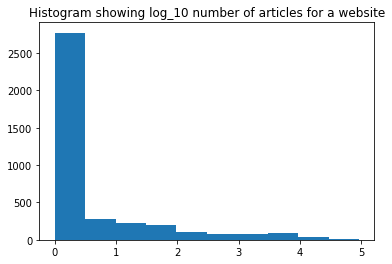

In [ ]:
plt.hist(np.log10(web.values))
plt.title('Histogram showing log_10 number of articles for a website')
plt.show()

Many of the 'websites' we have are probably mistakes (due to a domain name that changes). We thus toss them out.

In [ ]:
ind_li = []
for i in tqdm(range(len(web))):
    if web.iloc[i,0] < 100:
        ind_li.append(
            np.array(list((cleaned_res[cleaned_res['Website'] == web.index[i]]).index))
        )
        
ind_li = np.concatenate(ind_li).astype(int)
cleaned_res = cleaned_res.drop(ind_li)

cleaned_res.index = range(0,len(cleaned_res))

100%|██████████| 3882/3882 [06:18<00:00, 10.26it/s]


In [ ]:
cleaned_res

,Website,Cleaned URL
0,dialog.ua.edu,"[the, myth, of, martyrdom]"
1,thehindu.com,"[cities, delhi, over, fireworks, stalls, gutte..."
2,arkansasonline.com,"[feb, chilly, air, grips, state, snow, possibl..."
3,theguardian.com,"[politics, dec, nick, clegg, pmqs, increasingl..."
4,feedproxy.google.com,"[dailymail, home, k, shoppers, final, xmas]"
...,...,...
1806061,zeenews.india.com,"[ferguson, policies, targeted, blacks, created..."
1806062,theage.com.au,"[afl, afl, ryan, griffen, already, paying, his..."
1806063,dissidentvoice.org,"[what, did, people, do, before, the, war, daddy]"
1806064,wkzo.com,"[oct, us, national, security, prosecutors, shi..."


The cleaning is over, we will now process the data

In [ ]:
cleaned_res.to_pickle('cleaned_res.pkl') 

# 2. Word level embedding

Start from here without running the previous code if cleaned_res.pkl already exists to save time

In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

In [ ]:
cleaned_res = pd.read_pickle('cleaned_res.pkl')
tok = cleaned_res['Cleaned URL']

Now that our url's are cleaned we will train a Word2vec to embed our data

In [ ]:
from gensim.models import Word2Vec
from multiprocessing import cpu_count

cpu = cpu_count()

print("Training the URL W2V ...")
url = Word2Vec(tok, size=100, window=5, min_count=3, workers=cpu)
url.train(tok, total_examples=len(tok), epochs=10)

wv = url.wv

Training the URL W2V ...


In [ ]:
print('There are '+str(len(wv.vocab.keys())) + ' unique words in this dataset!')

There are 85740 unique words in this dataset!


## Qualitative analysis of this embedding
Let's look at words most similar to 'selfie' and 'war' to get a feel of how accurate the embedding is.
At first glance it looks accurate.

In [ ]:
wv.most_similar('selfie', topn = 10)

[('selfies', 0.675609290599823),
 ('photo', 0.5234270691871643),
 ('picture', 0.5227267146110535),
 ('tattoos', 0.521005392074585),
 ('photoshoot', 0.5145403146743774),
 ('blonde', 0.5016199946403503),
 ('photograph', 0.4911169409751892),
 ('onesie', 0.4898644685745239),
 ('latex', 0.4852360785007477),
 ('photoshop', 0.46837329864501953)]

In [ ]:
wv.most_similar('war', topn = 10)

[('conflict', 0.5586923360824585),
 ('disobedience', 0.5394599437713623),
 ('atrocities', 0.5114937424659729),
 ('ww', 0.49922433495521545),
 ('aggression', 0.4788926839828491),
 ('humanity', 0.47490280866622925),
 ('impunity', 0.4623667597770691),
 ('liberties', 0.44553422927856445),
 ('battle', 0.4449853301048279),
 ('occupation', 0.4429374933242798)]

## How do we vectorize our url's?

As in lab 3 we first summarize an url by the mean of its tokens ($\frac{1}{n} \Sigma x_i$) 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import numpy as np

def tokens2vectors(tokenCorpus, trained_word2vec, dim=100):
    new_sample = list()
    for sample in tqdm(tokenCorpus):
        tweetVecs = list()
        for token in sample.split(' '):
            try:
                tweetVecs.append(trained_word2vec.get_vector(token)  )
            except:
                tweetVecs.append(np.zeros(dim) ) 

        new_sample.append(np.mean(tweetVecs, axis=0))
    return np.array(new_sample)

In [ ]:
## the tokens2vectors functions takes whole sequences into account

tok_val = tok.values

for i in range(len(tok)):
    tok_val[i] = ' '.join(tok_val[i])

In [ ]:
X = tokens2vectors(tok_val,wv)

100%|██████████| 1806066/1806066 [01:21<00:00, 22027.23it/s]


### We then use the PCA decomposition to get quantitative measures of embedding quality

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
y = pca.transform(X)

In [ ]:
y = pca.transform(X)

In [ ]:
cleaned_res['pca1'] = y.T[0]
cleaned_res['pca2'] = y.T[1]

Are these pca components usefull? Let's look at two random newspapers and see if their urls (through their pca components) are separated

In [ ]:
zeenew_pca = cleaned_res[cleaned_res['Website'] == 'zeenews.india.com' ][['pca1','pca2']].values
thestar_pca = cleaned_res[cleaned_res['Website'] == 'thestar.com.my' ][['pca1','pca2']].values

In [ ]:
plt.figure(figsize=(9,9))
plt.scatter(y.T[0],y.T[1])
plt.scatter(zeenew_pca.T[0],zeenew_pca.T[1])
plt.scatter(thestar_pca.T[0],thestar_pca.T[1])

This is not that surprizing: most newspapers are generalists.  

# 3. Clustering our dataset to detect topics in an unsupervized way

Because we work with unlabelled data we have to resort to unsupervized learning. Our hypothesis is slightly changed for now. Let's see if we can detect interesting clusters which might relate to different topics

We use the elbow method to find an adequate number of clusters

In [ ]:
K = range(6,22)
distortions = []

#"""" Very long computation!!
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k,max_iter=8, verbose=1,n_init=1)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
#     """"

In [ ]:
plt.plot(K,distortions)

### What kind of clustering

This typical clustering method is perhaps not so adequate in our situation. By using a larger and larger amount of clusters we might well simply uncover subcategories of existing topics. For instance Rugby and Soccer are both subcategories of Sports.

We will try two different numbers of clusters: 8 and 40. Hopefully the first

In [ ]:
from sklearn.cluster import KMeans
# this example uses only 3 initializations to be fast (but less effective!)
kmeans_8 = KMeans(n_clusters=8, random_state=42, n_init=1, max_iter=100, verbose=1).fit(X)

kmeans_40 = KMeans(n_clusters=40, random_state=42, n_init=1, max_iter=100, verbose=1).fit(X)


In [ ]:
clusters_8 = kmeans_8.predict(X)
clusters_40 = kmeans_40.predict(X)

What kind of words are present in each centroid?

In [ ]:
vocab = np.array(list(wv.vocab.keys())) # contains all the vocabulary present in the URLs

In [ ]:
vocab_embed = np.zeros((len(vocab),100)) #vocab_embed represents the embedding for each word in the vocab
for i in range(len(vocab)):
    vocab_embed[i] = wv.get_vector(vocab[i])  

In [ ]:
# taking an instantated kmeans and the clusters, this function examines their centroids    
def look_at_centroids(kmean, clusters): 
    for i in range(len(kmean.cluster_centers_)):
        cent = kmean.cluster_centers_[i]
        res = []
        for j in range(len(vocab_embed)):
            res.append(np.linalg.norm(cent - vocab_embed[j] ))
        indices = [x for _, x in sorted(zip(res,range(len(res))))]
        print('Top 10 words closest to centroid center number: ' + str(i))
        print(vocab[indices[:10]])
        
        url_ind = np.argmin(clusters!= i)
        print()
        print('Sample URL contained in this cluster, coming from "'+ cleaned_res['Website'][url_ind] + '": ')
        print('" '+cleaned_res['Cleaned URL'][url_ind]+' " ')
        print()
        print(35*'-')


Comparing the 8 and the 40 clusters the improvement is obvious.

In [ ]:
look_at_centroids(kmeans_8,clusters_8)

In [ ]:
look_at_centroids(kmeans_40,clusters_40)

### How are these clusters balanced?

In [ ]:
plt.hist(clusters_8)
plt.title('Histogram of urls per cluster  (8 Clusters) ')

In [ ]:
plt.hist(clusters_40)
plt.title('Histogram of urls per cluster  (40 Clusters) ')

In [ ]:
cleaned_res['Cluster_8'] = clusters_8
cleaned_res['Cluster_40'] = clusters_40

In [ ]:
cleaned_res

In [ ]:
new_web = cleaned_res.groupby(['Website']).count()['Cleaned URL']
new_web

In [ ]:
cleaned_res.to_pickle('clustered_cleaned_res.pkl') 

## Looking at the proportion of clusters for each website

In [ ]:
nytimes = cleaned_res[cleaned_res['Website'] == 'nytimes.com']
forbes = cleaned_res[cleaned_res['Website'] == 'forbes.com']
hindu = cleaned_res[cleaned_res['Website'] == 'thehindu.com']

In [ ]:
plt.hist(nytimes['Cluster_40'])

In [ ]:
nytimes

In [ ]:
c4 = cleaned_res[cleaned_res['Cluster_40'] == 4]
c2 = cleaned_res[cleaned_res['Cluster_40'] == 2]
c0 = cleaned_res[cleaned_res['Cluster_40'] == 0]

In [ ]:
c4

# 4. Sentiment Analysis on the articles

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

cleaned_res = pd.read_pickle('clustered_cleaned_res.pkl')

We will now choose a cluster and study the way the sites talk about its related topics. For this, since we do not have a training base for sentiment analysis, we will directly use the pre-trained base offered by the nltk package.

In [ ]:
# Selects a cluster obtained by k-means and predicts the trend of the articles

def cluster_sentiment(kmean, c) :

  cluster = cleaned_res[cleaned_res['Cluster_40'] == c][['Website','Cleaned URL']]

  print("####################################################")
  print("STUDIED CLUSTER : ", c)
  print("####################################################")

  cent = kmean.cluster_centers_[c]
  res = []
  for j in range(len(vocab_embed)):
    res.append(np.linalg.norm(cent - vocab_embed[j] ))
  indices = [x for _, x in sorted(zip(res,range(len(res))))]
  print('Top 10 words closest to centroid center number: ' + str(c))
  print(vocab[indices[:10]])
  print('----------------------------------------------------')

  Sentiment = cluster['Cleaned URL'].apply(lambda x : sia.polarity_scores("".join(x)))
  cluster.insert(len(cluster.columns),'Sentiment',Sentiment)

  for elem in ['neg','neu','pos','compound'] :
    cluster.insert(len(cluster.columns),elem,cluster['Sentiment'].apply(lambda x : x[elem]))

  cluster.insert(len(cluster.columns),'Trend',cluster['compound'].apply(lambda x : "Positive" if x > 0 else ("Negative" if x < 0 else "Neutral")))

  print(cluster.value_counts('Trend'))
  print('----------------------------------------------------')

  cluster = cluster[cluster['compound'] != 0]
  cluster.insert(len(cluster.columns),'Trend_int',cluster['Trend'].apply(lambda x : 1 if x == 'Positive' else 0))

  return cluster

In [ ]:
cluster_sentiment(kmeans_40,5).head()

## First method : Compound discrimination

The first step is to display the frequency distribution of positive articles per newspaper in a given cluster.

In [ ]:
def plot_hist_compound(cluster, c = -1, key_words = []) :

  affinity = cluster[['Website','Trend_int']].groupby('Website').mean()

  count, bins_count = np.histogram(affinity)

  pdf = count / sum(count)
  cdf = np.cumsum(pdf)
  
  if c >= 0 :
    plt.figure("Cluster " + str(c))
    plt.plot(bins_count[1:], pdf, color="red", label="PDF")
    plt.plot(bins_count[1:], cdf, color="blue", label="CDF")
    plt.title("PDF and CDF of cluster number " + str(c))
    plt.legend()
    plt.show()

  else :
    plt.figure("Cluster with key words : " + str(key_words))
    plt.plot(bins_count[1:], pdf, color="red", label="PDF")
    plt.plot(bins_count[1:], cdf, color="blue", label="CDF")
    plt.title("PDF and CDF of the cluster")
    plt.legend()
    plt.show()

By selecting the typical graph cases that can be obtained, we obtain this kind of distribution:



In [ ]:
analyzed_clusters = [7,11,27,34]

for c in analyzed_clusters :

  cluster = cluster_sentiment(kmeans_40, c)
  if len(cluster) > 0 :
    plot_hist_compound(cluster,c)
  else :
    print("No non neutral article in the cluster no " + str(c))

The graph of cluster 34 shows, for example, that articles close to the keywords 'men', 'attacks', 'policemen' etc, are quite rarely neutral and take a very positive or negative view.

However, clusters are not always very meaningful and may group together articles dealing with very different subjects. Thus, instead of doing this work on the clusters obtained previously (and which are not always significant), we can try to choose the articles which contain a given word.

In [ ]:
def common_word(l1,key_words) :

  for word in key_words :
    if word in l1 :
      return True
 
  return False


def thematic_sentiment(cleaned_res, key_words) :

  print("### Construction of the thematic cluster ###")
  print('Key words used : ', key_words)

  cleaned_res.insert(len(cleaned_res.columns),"Thematic",cleaned_res['Cleaned URL'].apply(lambda x : common_word(x,key_words)))
  print(cleaned_res.value_counts(['Thematic']))
  print("-----------------------------------------")
  them_cluster = cleaned_res[cleaned_res['Thematic'] == True]
  del cleaned_res['Thematic']

  Sentiment = them_cluster['Cleaned URL'].apply(lambda x : sia.polarity_scores("".join(x)))
  them_cluster.insert(len(them_cluster.columns),'Sentiment',Sentiment)

  for elem in ['neg','neu','pos','compound'] :
    them_cluster.insert(len(them_cluster.columns),elem,them_cluster['Sentiment'].apply(lambda x : x[elem]))

  them_cluster.insert(len(them_cluster.columns),'Trend',them_cluster['compound'].apply(lambda x : "Positive" if x > 0 else ("Negative" if x < 0 else "Neutral")))

  print(them_cluster.value_counts('Trend'))
  print("-----------------------------------------")

  them_cluster = them_cluster[them_cluster['compound'] != 0]
  them_cluster.insert(len(them_cluster.columns),'Trend_int',them_cluster['Trend'].apply(lambda x : 1 if x == 'Positive' else 0))

  print("Size of the thematic cluster : " + str(len(them_cluster)))

  return them_cluster

In [ ]:
thematics = [["bank","finance"],
             ["social","health"],
             ["unemployment","employment","work"],
             ["immigration","refugee"],
             ["environment","climate","pollution"]]

for key_words in thematics :

  them_cluster = thematic_sentiment(cleaned_res, key_words)
  plot_hist_compound(them_cluster, c = -1, key_words = key_words)

For some topics, such as banking and finance, we can see that the sites are broadly divided into three types, visible in the three peaks of the red curve. On the left, sites that publish exclusively negative articles; on the right, sites that use mostly positive expressions. Finally, in the middle, the sites with a neutral tendency.

## Second method : Clustering

We can also use the three values obtained for the positivity, neutrality and negativity score and try to cluster the articles on a given theme.

In [ ]:
### Prend en entrée un cluster thématique et clusterise en fonction des trois valeurs 'pos', 'neg' et 'neu'
from sklearn.cluster import KMeans

def clust(them_cluster) :

  print("### Construction of the three clusters ###")
  X = []
  for i in them_cluster.index :
    line = them_cluster.loc[i]
    X.append([line['neg'],line['neu'],line['pos']])

  kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
  clusters_3 = kmeans.predict(X)

  them_cluster['Cluster_3'] = clusters_3

  return them_cluster

In [ ]:
# Affiche les clusters sur les articles

def plot_them_cluster(them_cluster) :

  plt.figure(figsize=(9,9))
  colors = ['red','blue','green']

  for k in range(3) :

    clust = them_cluster[them_cluster['Cluster_3'] == k]
    plt.scatter(clust['pos'], clust['neg'], c = colors[k])

  plt.show()

# Affiche les articles d'un même site sur l'ensemble des articles

def plot_websites(them_cluster, websites) :

  plt.figure(figsize=(9,9))

  for website in websites :

    website_cluster = them_cluster[them_cluster['Website'] == website]
    plt.scatter(website_cluster['pos'],website_cluster['neg'],label=website)

  plt.xlabel("Positivity")
  plt.ylabel("Negativity")
  plt.legend()
  plt.show()

In [ ]:
thematics = [["bank","finance","market","stock"],
             ["social","health"],
             ["unemployment","employment","work"],
             ["immigration","refugee"],
             ["environment","climate","pollution"]]

for key_words in thematics :

  them_cluster = thematic_sentiment(cleaned_res, key_words)
  them_cluster = clust(them_cluster)
  plot_them_cluster(them_cluster)
  ind = them_cluster['Website'].value_counts().iloc[:3].index
  plot_websites(them_cluster,ind)
  ind = them_cluster['Website'].value_counts().iloc[:3].index
  plot_websites(them_cluster,ind)


You can also look at some well-known English-language newspapers:

In [ ]:
# newspapers = ['theguardian.com','thetimes.co.uk','nytimes.com','washingtonpost.com','economist.com','forbes.com']
newspaper = ['theguardian.com']
thematics = [["bank","finance","market","stock"],
             ["social","health"],
             ["unemployment","employment","work"],
             ["immigration","refugee"],
             ["environment","climate","pollution"]]

for key_words in thematics :

  them_cluster = thematic_sentiment(cleaned_res, key_words)
  them_cluster = clust(them_cluster)
  plot_them_cluster(them_cluster)
  plot_websites(them_cluster,newspapers)